In [1]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')

In [2]:
def removed_outliers(df, column, level=3):
    return df[((df[column] - df[column].mean()) / df[column].std()).abs() < level]

def get_column_from_many_csv(filenames, col_num):
    intermediate_df = pd.DataFrame()
    for i, path in enumerate(filenames):
        df = pd.read_csv(path, skiprows=1)
        intermediate_df[i] = df.iloc[:, col_num]
    return intermediate_df

In [3]:
def smoothen_plot(x, y, smooth_power=300):
    smoothened_x = np.linspace(x.min(), x.max(), smooth_power)
    spl = make_interp_spline(x, y, k=3)
    smoothened_y = spl(smoothened_x)
    return smoothened_x, smoothened_y

In [4]:
def plot_ac_u_comp(df, clean=3, smooth_u=False, smooth_ac=False, draw_v_lines=False):
    if clean:
        cleaned_df = removed_outliers(df, 'ac_iter_time', level=clean)
        cleaned_df = removed_outliers(cleaned_df, 'u_iter_time', level=clean)
        cleaned_df.reset_index(drop=True, inplace=True)
    else:
        cleaned_df = df

    _, ax = plt.subplots(figsize=(15, 5))

    if smooth_ac:
        new_iter_no, ac_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.ac_iter_time, 180)
    else:
        new_iter_no, ac_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.ac_iter_time
    ax.plot(new_iter_no, ac_iter_time_smooth, label='Active cells unified memory', c='black', ls='-.')


    if smooth_u:
        new_iter_no, u_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.u_iter_time, 180)
    else:
        new_iter_no, u_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.u_iter_time
    ax.plot(new_iter_no, u_iter_time_smooth, label='Non-active cells unified memory', c='black', ls=':')

    iteration_no = cleaned_df['iteration_no']

    first_100 = (cleaned_df['ac_coverage'] == 100).idxmax()
    # if draw_v_lines:
    #     ax.axvline(x=iteration_no[first_100], lw=1, ls='--', c='black')
    #     ax.text(iteration_no[first_100] - 150, 1300, 'All cells are active', rotation=90)

    cross_point = ((cleaned_df['ac_iter_time'] - cleaned_df['u_iter_time']).abs()).idxmin()
    if draw_v_lines:
        ax.axvline(x=iteration_no[cross_point], lw=1, ls='--', c='black')
        ax.text(iteration_no[cross_point] - 50, ax.get_ylim()[0] + 10, 'Iteration time crossover', rotation=90)

    xs = [i for i in range(cleaned_df.shape[0]) if i % 300 == 0] + [cross_point, first_100]
    xticks = [iteration_no[i] for i in xs]

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Iteration time [μs]')
    ax.set_xticks(xticks)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Fraction of active cells in CA')

    secax.set_xticks(xticks)
    secax.set_xticklabels([
        f'{cleaned_df[cleaned_df.iteration_no == i].ac_coverage.iloc[0]:.2f}%'
        for i in xticks
    ])

    plt.legend()
    plt.show()

### Averaged standard results (100)

In [8]:
ac_to_avg = glob('unical_mount_point/coverage_tests_standard/active_cells')

inter_df = pd.DataFrame()
for i, path in enumerate(ac_to_avg):
    df = pd.read_csv(path, skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time'])
    inter_df[i] = df.ac_iter_time

avg_1000_comp = pd.read_csv(ac_to_avg[0], skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time'])
avg_1000_comp['ac_iter_time'] = inter_df.median(axis=1)

u_to_avg = glob('unical_mount_point/u_cov_[0-9]*')

inter_df = pd.DataFrame()
for i, path in enumerate(u_to_avg):
    df = pd.read_csv(path, skiprows=1, names=['iteration_no', 'u_coverage', 'u_iter_time'])
    inter_df[i] = df.u_iter_time

avg_1000_comp['u_iter_time'] = inter_df.median(axis=1)

first_100 = (avg_1000_comp['ac_coverage'] == 100).idxmax()
avg_1000_comp = avg_1000_comp.iloc[:first_100 + 1]

avg_1000_comp.describe()

,iteration_no,ac_coverage,ac_iter_time,u_iter_time
count,788.000000,788.000000,788.000000,788.000000
mean,3945.000000,63.066104,2622.582487,2523.992386
std,2276.202979,32.205870,895.130719,145.966968
min,10.000000,0.040725,1237.000000,2333.000000
25%,1977.500000,35.158838,1926.250000,2397.000000
50%,3945.000000,68.667075,2590.250000,2509.500000
75%,5912.500000,95.379361,3379.000000,2620.500000
max,7880.000000,100.000000,14043.000000,3257.000000


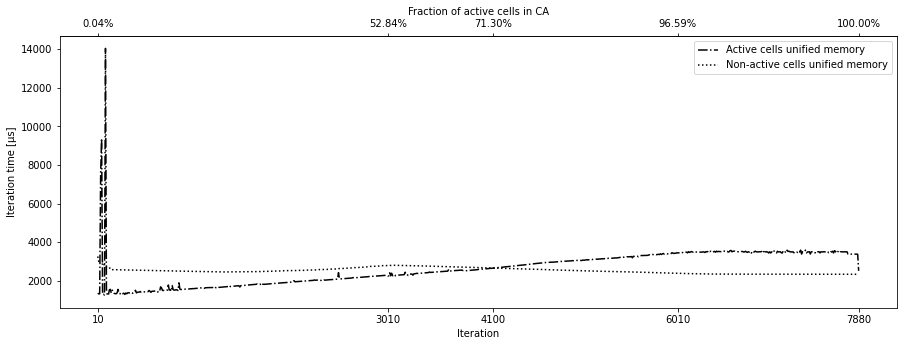

In [9]:
plot_ac_u_comp(avg_1000_comp, clean=False, draw_v_lines=False)

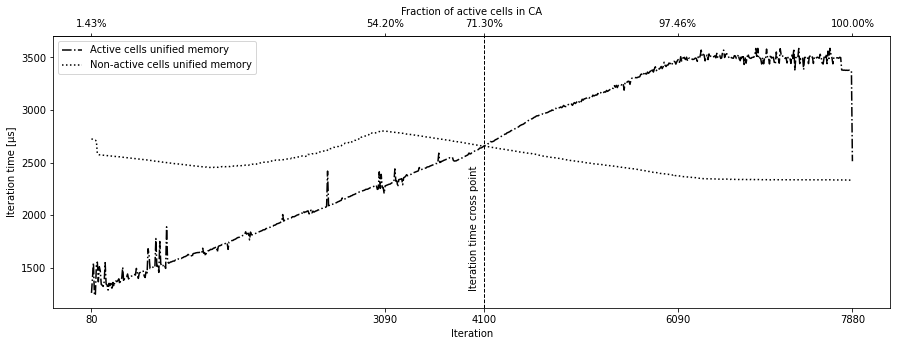

In [10]:
plot_ac_u_comp(avg_1000_comp, clean=3, draw_v_lines=True)

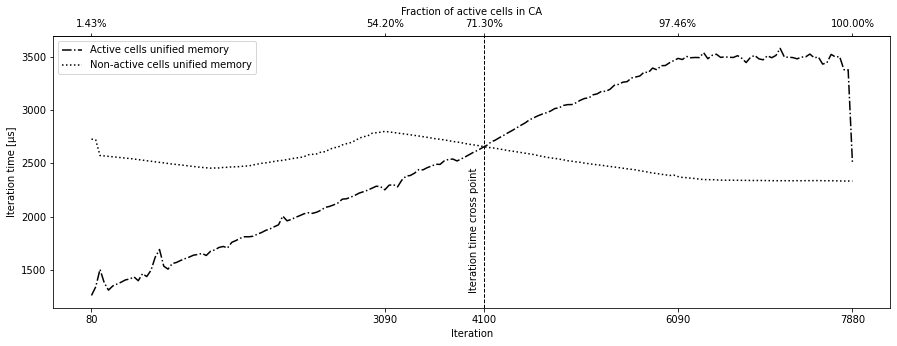

In [11]:
plot_ac_u_comp(avg_1000_comp, clean=3, smooth_ac=True, smooth_u=True, draw_v_lines=True)

### Averaged stress results

In [21]:
ac_to_avg = glob('unical_mount_point/stress_test/active_cells_loop_*')

active_cell_cols = ['iteration_no', 'ac_coverage', 'ac_iter_time', 'ac_trans_time', 'ac_find_time']
inter_df = pd.DataFrame()
ac_trans_df = pd.DataFrame()
ac_find_df = pd.DataFrame()

for i, path in enumerate(ac_to_avg):
    df = pd.read_csv(path, skiprows=1, names=active_cell_cols)
    inter_df[i] = df.ac_iter_time
    ac_trans_df[i] = df.ac_trans_time
    ac_find_df[i] = df.ac_find_time

avg_20_loop_comp = pd.read_csv(ac_to_avg[0], skiprows=1, names=active_cell_cols)

avg_20_loop_comp['ac_iter_time'] = inter_df.min(axis=1)
avg_20_loop_comp['ac_trans_time'] = ac_trans_df.min(axis=1)
avg_20_loop_comp['ac_find_time'] = ac_find_df.min(axis=1)

u_to_avg = glob('unical_mount_point/stress_test/unified_loop_*')

avg_20_loop_comp['u_iter_time'] = get_column_from_many_csv(u_to_avg, 2).min(axis=1)

first_100 = (avg_20_loop_comp['ac_coverage'] == 100).idxmax()
avg_20_loop_comp = avg_20_loop_comp.iloc[:first_100 + 1]

avg_20_loop_comp.describe()

,iteration_no,ac_coverage,ac_iter_time,ac_trans_time,ac_find_time,u_iter_time
count,788.000000,788.000000,788.000000,788.0,788.0,788.000000
mean,3936.000000,62.908754,247.522843,0.0,0.0,333.444162
std,2276.202979,32.198960,112.429611,0.0,0.0,9.802402
min,1.000000,0.000225,49.000000,0.0,0.0,266.000000
25%,1968.500000,34.984462,144.750000,0.0,0.0,333.000000
50%,3936.000000,68.563575,266.000000,0.0,0.0,337.000000
75%,5903.500000,94.873043,361.000000,0.0,0.0,338.000000
max,7871.000000,100.000000,387.000000,0.0,0.0,339.000000


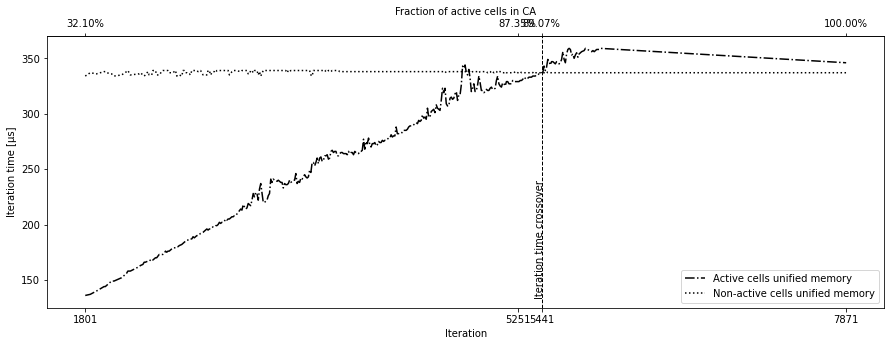

In [22]:
plot_ac_u_comp(avg_20_loop_comp, clean=True, draw_v_lines=True)

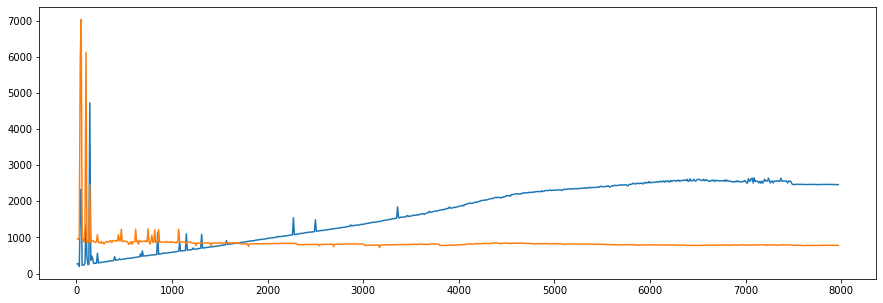

In [26]:
_, ax = plt.subplots(figsize=(15, 5))
ax.plot(avg_20_loop_comp.iteration_no, avg_20_loop_comp.ac_trans_time)
ax.plot(avg_20_loop_comp.iteration_no, avg_20_loop_comp.ac_find_time)

### Crossover

In [10]:
crossover_ac = sorted(glob('unical_mount_point/coverage_tests/active_cells_*'))
ca_sizes = sorted(set(filepath.split('_')[-6] for filepath in crossover_ac))

active_cell_cols = ['iteration_no', 'ac_coverage', 'ac_iter_time', 'ac_trans_time', 'ac_find_time']
crossovers = dict()

for ca_size in ca_sizes:
    crossover_ac = sorted(glob(f'unical_mount_point/coverage_tests/active_cells_32_{ca_size}*'))
    crossover_u = sorted(glob(f'unical_mount_point/coverage_tests/unified_memory_32_{ca_size}*'))

    avg_crossover_df = pd.DataFrame()
    avg_crossover_df['ac_iter_time'] = get_column_from_many_csv(crossover_ac, 2).mean(axis=1)
    avg_crossover_df['ac_coverage'] = pd.read_csv(crossover_ac[0], skiprows=1, names=active_cell_cols).ac_coverage
    avg_crossover_df['u_iter_time'] = get_column_from_many_csv(crossover_u, 2).mean(axis=1)

    crossover_idx = (avg_crossover_df.ac_iter_time - avg_crossover_df.u_iter_time).abs().idxmin()

    coverage = avg_crossover_df.ac_coverage.iloc[crossover_idx]

    crossovers[ca_size] = coverage
crossovers

{'4000': 1.0,
 '5000': 0.63822336,
 '5500': 0.6610850909090911,
 '6000': 0.677493,
 '6500': 0.661653775147929,
 '6750': 0.035065766803841006,
 '7000': 0.6633727346938779,
 '7250': 0.6643547015457789,
 '7500': 0.66904576}